In [1]:
import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        #self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        #self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=0.01, 
            max_iter=1000,
            max_eval=500, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, t):  
        u = self.dnn(t)
        return u
    
    def net_f(self, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t - torch.cos(2*torch.pi*t)
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.t_u)
        f_pred = self.net_f(self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        #x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X, requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(t)
        f = self.net_f(t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [7]:
N_u = 100
N_f = 10000
layers = [1]+2*[20] +[1]

t= np.linspace(0,3,1000)
Exact = (1/ (2*np.pi))*np.sin(2*np.pi*t)+1

#data = scipy.io.loadmat('burgers_shock.mat')

#t = data['t'].flatten()[:,None]
#x = data['x'].flatten()[:,None]
#Exact = np.real(data['usol']).T

#X, T = np.meshgrid(x,t)

#X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
#u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = t.min(0)
#ub = t.max(0)    

# X axis at time 0
#xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0]

# X lower boundary through time
#xx2 = np.hstack((X[:,0:1], T[:,0:1]))
#uu2 = Exact[:,0:1]

# X upper boundary through time 
#xx3 = np.hstack((X[:,-1:], T[:,-1:]))
#uu3 = Exact[:,-1:]

X_u_train = np.repeat(lb,N_u).flatten()[:,None] 
X_f_train = lhs(1, N_f)*2
X_f_train = X_f_train- X_f_train.min()
u_train = np.repeat(uu1,N_u).flatten()[:,None] 

idx = np.random.choice(X_f_train.shape[0], N_u, replace=False)
#X_u_train = X_u_train[idx, :]
#u_train = u_train[idx,:]

In [8]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb)


In [9]:
model.train()


Iter 100, Loss: 2.94688e-01, Loss_u: 9.55919e-04, Loss_f: 2.93732e-01
Iter 200, Loss: 1.48756e-01, Loss_u: 3.41667e-04, Loss_f: 1.48415e-01
Iter 300, Loss: 4.97739e-03, Loss_u: 5.55773e-06, Loss_f: 4.97184e-03
Iter 400, Loss: 1.90575e-04, Loss_u: 9.74980e-07, Loss_f: 1.89600e-04
Iter 500, Loss: 8.26476e-05, Loss_u: 2.42385e-08, Loss_f: 8.26234e-05


In [10]:
u_pred, f_pred = model.predict(t.flatten()[:,None] )

error_u = np.linalg.norm(Exact-u_pred,2)/np.linalg.norm(Exact,2)
print('Error u: %e' % (error_u))                     

Error u: 1.166517e+01


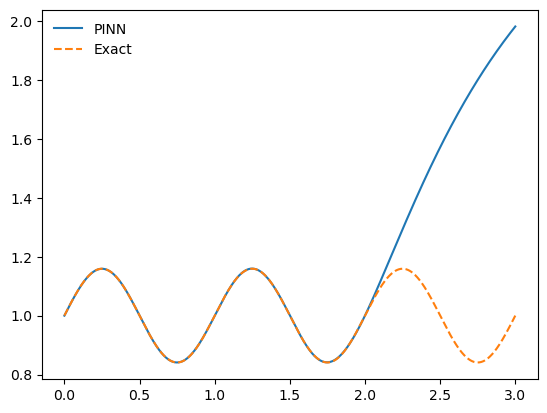

In [11]:
plt.plot(t, u_pred, label = "PINN")
plt.plot(t,Exact,linestyle='dashed', label = "Exact")
plt.legend(frameon=False)